<img align="right" width="100" height="100" src="https://jatinangor.itb.ac.id/wp-content/uploads/sites/17/2012/12/Logo-ITB-polos20-1.jpg">

# Seismologi Komputasi - Tugas 3
*Farhan Hamid Lubis - 22319310*<br>
*Rizky Adityo Prastama - 22319311*
***
## Estimasi Traveltime dengan Finite Difference (Vidale, 1988)
***

### Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(precision = 2)

***
### Step 1: Input Parameter dan Pembuatan Matriks Offset `x` & Kedalaman `z`

Tahap pertama yang dilakukan adalah memasukkan parameter dari model lapisan yang akan digunakan. Pada tahap ini, input yang diperlukan adalah:
1. Kecepatan lapisan (`v`) dalam km/s.
2. Ketebalan lapisan (`v_dz`) dalam km.
3. Panjang _cross-section_ (`distance_x`) dalam km.
4. Ukuran grid individu (`h`) dalam km.
5. Lokasi sumber (`source`). Nilai 1 untuk sumber pada pojok kiri atas *cross-section*, 2 untuk sumber di tengah atas *cross-section*, dan 3 untuk sumber di kanan atas *cross-section*.

Berdasarkan input yang diberikan, program akan secara otomatis membuat matriks offset `x` dan matriks kedalaman `z`. Ukuran matriks `x` dan `z` ditentukan oleh total ketebalan lapisan, panjang *cross-section*, serta ukuran grid individu. Semakin besar ukuran grid individu, semakin kecil ukuran matriks `x` dan `z` begitu pula sebaliknya.

In [2]:
v = np.array([3.0]) # kecepatan lapisan (km/s)
v_dz = np.array([50]) # ketebalan lapisan (km)
layers = len(v)

distance_x = 100 # offset cross-section (km)
distance_z = np.sum(v_dz)
h = 0.1 # grid spacing

grid_x = int(np.round((distance_x / h) + 1))
grid_z = int(np.round((distance_z / h) + 1))
grid = np.zeros([grid_z, grid_x])

In [3]:
# lokasi sumber dalam grid
source = 1 
### 1 = pojok kiri atas cross-section
### 2 = tengah atas cross-section
### 3 = kanan atas cross-section

if source == 1:
    source_x = 0
    source_z = 0
elif source == 2:
    source_x = np.round(grid_x / 2)
    source_z = 0
elif source == 3:
    source_x = np.round(grid_x - 1)
    source_z = 0
else:
    print("Wrong source location index! Exiting program...")
    exit()

# matriks offset dan kedalaman berdasarkan input yang diberikan
x = np.arange(0, np.round(distance_x + h, decimals = 2), h)
z = np.arange(0, np.round(distance_z + h, decimals = 2), h)
x, z = np.meshgrid(x, z)

***
### Step 2: Membuat Matriks *Slowness*

Ukuran matriks `slowness` yang dibuat akan mengikuti ukuran dari matriks offset `x` dan matriks kedalaman `z`. Matriks *slowness* akan digunakan sebagai informasi kelambanan medium di setiap titik grid.

In [4]:
v_z = np.zeros([1, layers + 1])
for i in range(1, layers + 1):
    v_z[0, i] = v_z[0, i - 1] + v_dz[i - 1]

v_grid = v_z / h

velo = np.zeros([grid_z, grid_x])

for j in range(np.shape(velo)[1]):
    for k in range(layers):
        for i in range(int(np.round(v_grid[0, k])), int(np.round(v_grid[0, k + 1]))):
            velo[i, j] = v[k]
            velo[i + 1, j] = v[k]

slowness = 1 / velo

***

<img align = "center" width = 40% src="img/loop_verlat.png">

### Step 3: Estimasi *Traveltime*

**Arah Vertikal dan Lateral**

Dari Vidale, waktu perambatan pada titik-titik yang sejajar secara lateral dan vertikal dari sumber dapat dihitung menggunakan persamaan berikut:
$$
t_{i} = \frac{h}{2} \left(s_{i} + s_{A}\right)
$$
dimana $t_{i}$ ada waktu pada titik $i$, $h$ adalah ukuran grid individu `h`, $s_{i}$ adalah nilai *slowness* pada titik $i$, dan $s_{A}$ adalah nilai *slowness* pada titik sumber. Titik $A$ tidak selalu menjadi sumber ledakan, namun dapat menjadi titik yang berada tepat di sebelah titik $i$ yang sudah memiliki nilai $t$.

In [5]:
t = np.zeros([grid_z, grid_x])
t[int(source_z), int(source_x)] = 0

# Perambatan lateral dari sumber
# Arah kiri
for i in reversed(range(0, int(source_x))):
    t[int(source_z), i] = t[int(source_z), i + 1] + ((h / 2) * (slowness[int(source_z), i] + slowness[int(source_z), i + 1]))
# Arah kanan
for i in range(int(source_x) + 1, grid_x):
    t[int(source_z), i] = t[int(source_z), i - 1] + ((h / 2) * (slowness[int(source_z), i] + slowness[int(source_z), i - 1]))

# Perambatan vertikal dari sumber
# Arah atas
for i in reversed(range(0, int(source_z))):
    t[i, int(source_x)] = t[i + 1, int(source_x)] + ((h / 2) * (slowness[i, int(source_x)] + slowness[i + 1, int(source_x)]))
# Arah bawah
for i in range(int(source_z) + 1, grid_z):
    t[i, int(source_x)] = t[i - 1, int(source_x)] + ((h / 2) * (slowness[i, int(source_x)] + slowness[i - 1, int(source_x)]))

<img align = "center" width = 70% src="img/loop_diag.png">

**Arah Diagonal**

Perambatan gelombang dua dimensi mengikuti persamaan eikonal _ray tracing_ berikut:
$$
\left(\frac{\partial t}{\partial x}\right)^{2} + \left(\frac{\partial t}{\partial z}\right)^{2} = s\left(x, z\right)^{2}
$$
Dalam *finite difference*, suku diferensial dapat didefinisikan sebagai berikut:
$$
\frac{\partial t}{\partial x} = \frac{1}{2h} \left(t_{0} + t_{2} - t_{1} - t_{3}\right) \\
\frac{\partial t}{\partial z} = \frac{1}{2h} \left(t_{0} + t_{1} - t_{2} - t_{3}\right)
$$
Sehingga:
$$
t_{3} = t_{0} + \sqrt{2(hs)^{2} - (t_{2} - t_{1})^2}
$$
dimana $t_{3}$ adalah waktu pada titik yang diapit oleh titik $1$ dan $2$ serta berseberangan dengan titik $0$ secara diagonal.

In [6]:
# Arah kanan
for i in range(int(source_x) + 1, grid_x):
    # Bagian atas
    for j in reversed(range(0, int(source_z))):
        t[j, i] = t[j + 1, i - 1] + np.sqrt(2 * (h * slowness[j, i])**(2) - (t[j + 1, i] - t[j, i - 1])**(2))
    # Bagian bawah
    for j in range(int(source_z) + 1, grid_z):
        t[j, i] = t[j - 1, i - 1] + np.sqrt(2 * (h * slowness[j, i])**(2) - (t[j - 1, i] - t[j, i - 1])**(2))

# Arah kiri
for i in reversed(range(0, int(source_x))):
    # Bagian atas
    for j in reversed(range(0, int(source_z))):
        t[j, i] = t[j + 1, i + 1] + np.sqrt(2 * (h * slowness[j, i])**(2) - (t[j + 1, i] - t[j, i + 1])**(2))
    # Bagian bawah
    for j in range(int(source_z) + 1, grid_z):
        t[j, i] = t[j - 1, i + 1] + np.sqrt(2 * (h * slowness[j, i])**(2) - (t[j - 1, i] - t[j, i + 1])**(2))

### Step 4: Plot Kontur *Traveltime*

Tahap ini merupakan pembuatan kontur dengan informasi berikut:
1. Matriks `x` sebagai informasi offset setiap grid
2. Matriks `z` sebagai informasi kedalaman setiap grid
3. Matriks `t` sebagai informasi *traveltime* setiap grid

Informasi berikut dapat diatur untuk mengubah tampilan dari kontur yang diinginkan:
1. `steps` untuk mengubah interval kontur
2. `fgz_scale` untuk mengubah panjang sisi maksimal dari kontur yang dibuat (dalam inch)

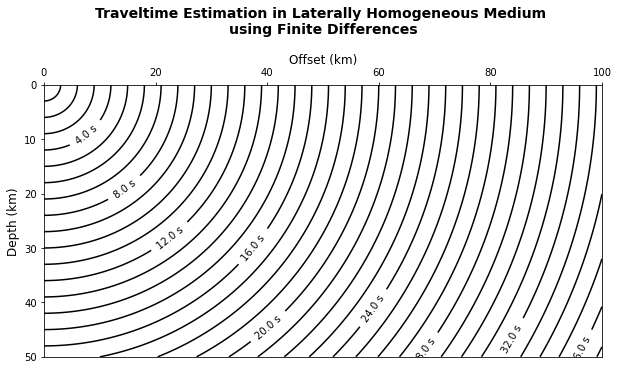

In [7]:
steps = 1 # interval kontur
max_lvl = np.round(np.amax(t))
lvl = np.arange(0, max_lvl + steps, steps)
label_lvl = np.arange(0, max_lvl + steps, steps + 3)

fig, ax = plt.subplots()
cs = ax.contour(x, z, t, levels = lvl, colors = 'k')

ax.set_title("Traveltime Estimation in Laterally Homogeneous Medium \nusing Finite Differences", pad = 20, fontdict = {'fontsize': 14, 'fontweight': 'bold'})
ax.set_xlabel("Offset (km)", fontdict = {'fontsize': 12, 'fontweight': 'medium'})
ax.set_ylabel("Depth (km)", fontdict = {'fontsize': 12, 'fontweight': 'medium'})

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

fgz_scale = 10 # panjang sisi maksimum dari kontur
fgz_x = (grid_x / max(grid_x, grid_z)) * fgz_scale
fgz_z = (grid_z / max(grid_x, grid_z)) * fgz_scale
fig.set_size_inches(fgz_x, fgz_z)

plt.gca().invert_yaxis()

ax.clabel(cs, levels = label_lvl, inline=True, fontsize = '10', inline_spacing=5, fmt='%1.1f s')

plt.show()